Notebook to generate data file that is a subset of the SGA catalog with rotational velocities measured during Y1 (iron).

In [1]:
import numpy as np

from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

from corner import corner

import matplotlib.pyplot as plt

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s
dz_sys = dv_sys/c.value
#### ultimately dz = (1+z) dv/c, but we will multiply this by (1+z) for each observation

# Data

## iron

In [3]:
# tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_iron_healpix.fits')
tiron = Table.read('/Users/kdouglass/Documents/Research/data/DESI/Y1/desi_pv_tf_iron_healpix.fits')
tiron[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
2852147603439621,198.369130660983,36.5372037049171,10475,main,0.815976335547845,7.38513168100107e-05,4,0.128754377365112,iron/healpix/main/dark/104/10475/redrock-main-dark-10475.fits,EXT,649377,198.36913066098333,36.537203704917076
2399148812795907,198.371733180003,36.4994335406917,10475,main,1.11088784970434,7.48767797671894e-05,4,7.9473560154438,iron/healpix/main/bright/104/10475/redrock-main-bright-10475.fits,EXT,649377,198.37173318000336,36.499433540691676
2399382443917318,184.845242475328,49.8157304793777,10995,main,1.14739342108157,0.000146302276719084,4,2.56771463155746,iron/healpix/main/bright/109/10995/redrock-main-bright-10995.fits,EXT,1008911,184.84524247532795,49.81573047937771
2399634072797192,184.341289722203,70.8283725474297,11965,main,1.51703376230705,6.28979649962091e-05,4,4.76254060305655,iron/healpix/main/bright/119/11965/redrock-main-bright-11965.fits,EXT,241234,184.34128972220284,70.82837254742968
2852141710442505,123.256011148025,36.2652948002806,6448,main,0.00787379494184006,3.4714052819995e-05,0,22.1719104201402,iron/healpix/main/dark/64/6448/redrock-main-dark-6448.fits,EXT,31591,123.25601114802525,36.26529480028061


### Update all Redrock uncertainties to account for 7 km/s statistical uncertainty

In [4]:
tiron['ZERR_MOD'] = np.sqrt(tiron['ZERR']**2 + (dz_sys*(1 + tiron['Z']))**2)

### Are $\sigma_z$ small relative to $z$?

In [5]:
np.max(tiron['ZERR_MOD']/tiron['Z'])

np.float64(38.776587730091535)

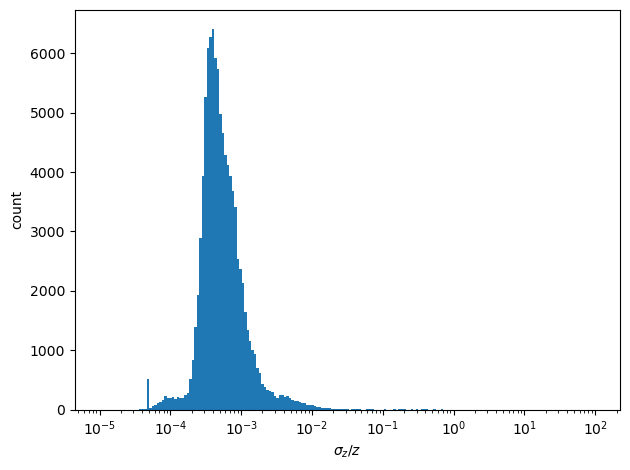

In [6]:
plt.figure(tight_layout=True)

plt.hist(tiron['ZERR_MOD']/tiron['Z'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

## SGA

In [7]:
# SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [8]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

# Separate the iron data into center and off-center observations

In [9]:
tiron['SKY_FIBER_DIST'] = 0.
tiron['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tiron['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tiron['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tiron['RA'][obs_idx], 
                             dec=tiron['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tiron['SKY_FIBER_DIST'][obs_idx] = sep2d
    tiron['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|████████████████████████████████████████████████████████████████████████████████████████| 75152/75152 [00:39<00:00, 1885.94it/s]


In [10]:
centers_boolean = tiron['SKY_FIBER_DIST_R26'] < 0.1

iron_centers = tiron[centers_boolean]
iron_axis = tiron[~centers_boolean]

## Clean the iron center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0
* passed VI

In [11]:
good_centers = iron_centers[(iron_centers['DELTACHI2'] > 25) & (iron_centers['ZWARN'] == 0)]
print(len(np.unique(good_centers['SGA_ID'])), len(good_centers))

70100 74852


In [12]:
iron_VI = Table.read('iron_VI.txt', format='ascii.commented_header')

centers_VI = np.ones(len(good_centers), dtype=bool)

for targetid in iron_VI['TARGETID']:
    
    if targetid in good_centers['TARGETID']:
        centers_VI = centers_VI & (good_centers['TARGETID'] != targetid)
        
good_centers_VI = good_centers[centers_VI]
print(len(np.unique(good_centers_VI['SGA_ID'])), len(good_centers_VI))

70095 74847


### How does $\sigma_z$ compare with $z$ for the good center observations?

In [13]:
print(np.max(good_centers['ZERR_MOD']/good_centers['Z']), np.max(iron_axis['ZERR_MOD']/iron_axis['Z']))

38.776587730091535 3.374315152884681


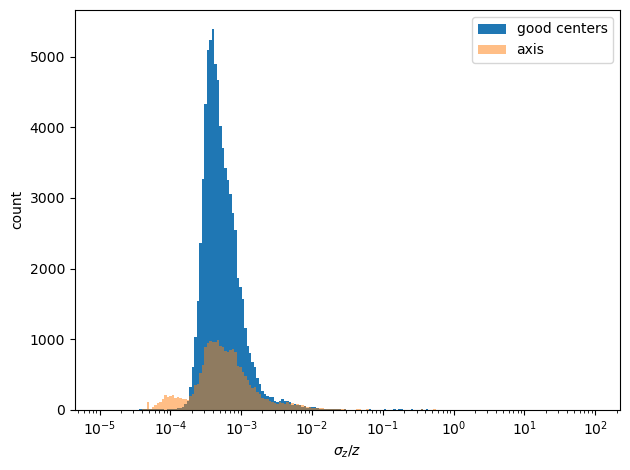

In [14]:
plt.figure(tight_layout=True)

plt.hist(good_centers['ZERR_MOD']/good_centers['Z'], bins=np.logspace(-5, 2, 200), label='good centers')
plt.hist(iron_axis['ZERR_MOD']/iron_axis['Z'], bins=np.logspace(-5, 2, 200), alpha=0.5, label='axis')

plt.xscale('log')

plt.legend()

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [15]:
rng = np.random.default_rng()

N_samples = 10000 # for large error propagation

In [16]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

# weights = 1./(good_centers_VI['ZERR']**2)
weights = 1./(good_centers_VI['ZERR_MOD']**2)

for sga_id in tqdm(np.unique(good_centers_VI['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers_VI['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers_VI['Z'][obs_idx], 
                                        weights=weights[obs_idx])

    # Compute the uncertainty in the center redshift
    if (N_obs == 1) or np.all(np.abs(good_centers_VI['ZERR_MOD'][obs_idx]/good_centers_VI['Z'][obs_idx]) < 0.05):
        SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1/np.sum(weights[obs_idx]))
    else:
        z_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            z_random[i] = rng.normal(loc=good_centers_VI['Z'][obs_idx][i], 
                                     scale=good_centers_VI['ZERR_MOD'][obs_idx][i], 
                                     size=N_samples)

        avg_z_random = np.average(z_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples), 
                                  axis=0)
        SGA['ZERR_DESI'][SGA_idx] = np.std(avg_z_random)

100%|████████████████████████████████████████████████████████████████████████████████████████| 70095/70095 [00:08<00:00, 7907.84it/s]


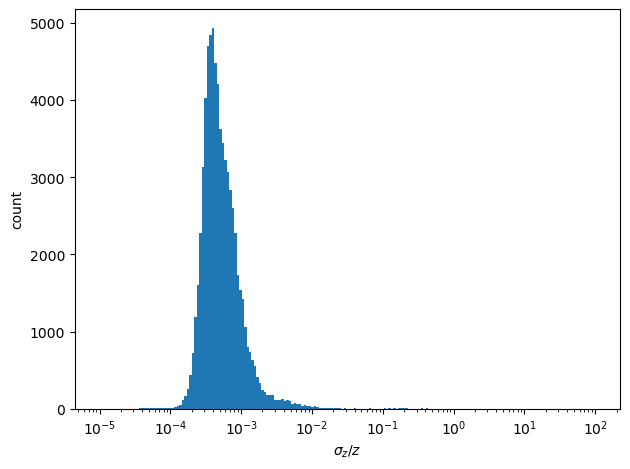

In [17]:
plt.figure(tight_layout=True)

plt.hist(SGA['ZERR_DESI']/SGA['Z_DESI'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

# Calculate the rotational velocities

In [18]:
iron_axis['V_ROT'] = np.nan
iron_axis['V_ROT_ERR'] = np.nan

# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in tqdm(np.unique(good_centers_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = iron_axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center = SGA['ZERR_DESI'][sga_idx]

    # Calculate rotational velocity for all observations of the galaxy
    # iron_axis['V_ROT'][obs_idx] = c*(iron_axis['Z'][obs_idx] - z_center)
    z_rot = (1 + iron_axis['Z'][obs_idx])/(1 + z_center) - 1
    iron_axis['V_ROT'][obs_idx] = c*z_rot
    
    # Calculate uncertainty in the rotational velocity
    if np.all(np.abs(iron_axis['ZERR_MOD'][obs_idx]/iron_axis['Z'][obs_idx]) < 0.05) and (z_err_center/z_center < 0.05):
        # iron_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(iron_axis['ZERR'][obs_idx]**2 + z_err_center**2)
        # iron_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((iron_axis['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + iron_axis['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
        iron_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((iron_axis['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + iron_axis['Z'][obs_idx])/(1 + z_center)**2))
    else:
        z_center_random = rng.normal(loc=z_center, 
                                     scale=z_err_center,
                                     size=N_samples)

        z_axis_random = np.zeros((np.sum(obs_idx), N_samples))

        for i in range(np.sum(obs_idx)):
            z_axis_random[i] = rng.normal(loc=iron_axis['Z'][obs_idx][i], 
                                          scale=iron_axis['ZERR_MOD'][obs_idx][i], 
                                          size=N_samples)

        z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

        iron_axis['V_ROT_ERR'][obs_idx] = np.std(np.abs(c*z_rot_random), axis=1)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    iron_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    iron_axis['V_ROT_ERR'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

100%|████████████████████████████████████████████████████████████████████████████████████████| 70095/70095 [00:14<00:00, 4986.68it/s]


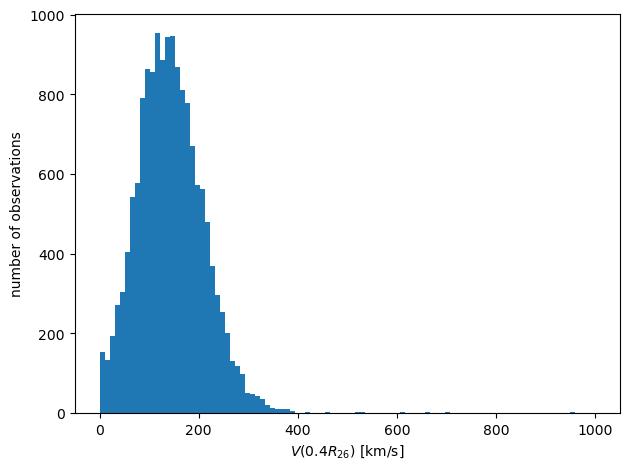

In [19]:
plt.figure(tight_layout=True)

plt.hist(np.abs(iron_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V(0.4R_{26})$ [km/s]')
plt.ylabel('number of observations');

# Quality criteria for velocities

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.4R_{26}$
* $\Delta V / V_{min} \leq 5$
* passes VI

## Velocity cut

In [20]:
r0p4 = (iron_axis['SKY_FIBER_DIST_R26'] > 0.38) & (iron_axis['SKY_FIBER_DIST_R26'] < 0.42)

Vgood = (np.abs(iron_axis['V_ROT']) < 1000) & (np.abs(iron_axis['V_ROT']) > 10)

good_axis = iron_axis[r0p4 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

15076 10497


## Visual inspection

Cutouts for this were generated with the `TF_Y1_VI.ipynb` notebook.

In [21]:
axis_VI = np.ones(len(good_axis), dtype=bool)

for targetid in iron_VI['TARGETID']:
    
    if targetid in good_axis['TARGETID']:
        axis_VI = axis_VI & (good_axis['TARGETID'] != targetid)
        
good_axis_VI = good_axis[axis_VI]
print(len(good_axis_VI), len(np.unique(good_axis_VI['SGA_ID'])))

15060 10488


## Relative velocity cut

In [22]:
good_deltaV = np.ones(len(good_axis_VI), dtype=bool)

for sga_id in tqdm(np.unique(good_axis_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_VI['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_VI['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_VI['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_VI['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_VI['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_VI['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_VI['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_VI['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_VI['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_VI['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_VI['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

100%|███████████████████████████████████████████████████████████████████████████████████████| 10488/10488 [00:00<00:00, 15762.80it/s]


In [23]:
good_deltaV_axis_VI = good_axis_VI[good_deltaV]

print(len(good_deltaV_axis_VI), len(np.unique(good_deltaV_axis_VI['SGA_ID'])))

15025 10478


# Compute the weighted average velocity for those galaxies with more than one observation at $0.4R_{26}$

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:11<00:00, 951.87it/s]


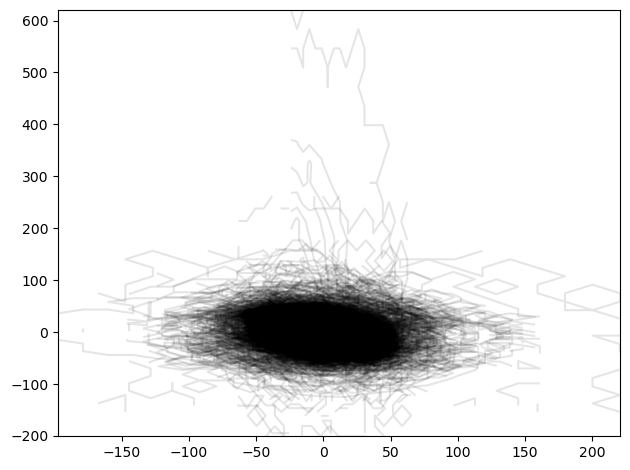

In [24]:
SGA['V_0p4R26'] = np.nan
SGA['V_0p4R26_ERR'] = np.nan

weights = 1./(good_deltaV_axis_VI['V_ROT_ERR']**2)

# contour_colors = iter(plt.cm.viridis(np.linspace(0,1,2600)))
fig, ax = plt.subplots(tight_layout=True)

for sga_id in tqdm(np.unique(good_deltaV_axis_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_deltaV_axis_VI['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    #---------------------------------------------------------------------------
    # Combine all redshifts that are measured in the same spot (i.e., on the 
    # same side of the galaxy)
    #---------------------------------------------------------------------------
    if N_obs > 1:
        # print('There is more than one observation on this galaxy')
        
        axis_z_list = []
        axis_z_err_list = []
        
        # Make a small table of just this galaxy
        this_gal = good_deltaV_axis_VI[obs_idx]

        weights_z = 1./(this_gal['ZERR_MOD']**2)
        
        # Observations that are on the same side as the first one in this list
        same_side = (this_gal['TARGET_RA'] == this_gal['TARGET_RA'][0]) & (this_gal['TARGET_DEC'] == this_gal['TARGET_DEC'][0])
        
        # Compute the weighted average redshift of all observations on the same 
        # side of the galaxy as the first one in the list
        avg_z_same = np.average(this_gal['Z'][same_side], 
                                weights=weights_z[same_side])
        avg_z_err_same = np.sqrt(1./np.sum(weights_z[same_side]))

        axis_z_list.append(avg_z_same)
        axis_z_err_list.append(avg_z_err_same)

        # If there are any observations on the other side from the first 
        # observation, compute their weighted average
        if np.sum(same_side) < N_obs:
            
            avg_z_opp = np.average(this_gal['Z'][~same_side], 
                                   weights=weights_z[~same_side])
            avg_z_err_opp = np.sqrt(1./np.sum(weights_z[~same_side]))

            axis_z_list.append(avg_z_opp)
            axis_z_err_list.append(avg_z_err_opp)

        # Grab the center redshift and uncertainty for this galaxy
        z_center = SGA['Z_DESI'][SGA_dict[sga_id]]
        z_err_center = SGA['ZERR_DESI'][SGA_dict[sga_id]]
        
        # Compute the rotational velocity of these average redshifts on either 
        # side
        axis_z_rot = (1 + np.array(axis_z_list))/(1 + z_center) - 1
        axis_V = np.abs(c.value*axis_z_rot)

        
        if (len(axis_V) > 1) or ((len(axis_V) == 1) and ((z_err_center/z_center > 0.05) or (avg_z_err_same/avg_z_same > 0.05))):
            
            z_center_random = rng.normal(loc=z_center, 
                                         scale=z_err_center,
                                         size=N_samples)
    
            z_axis_random = np.zeros((len(axis_z_list), N_samples))
    
            for i in range(len(axis_z_list)):
                z_axis_random[i] = rng.normal(loc=axis_z_list[i], 
                                              scale=axis_z_err_list[i], 
                                              size=N_samples)
    
            z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

            axis_V_err = np.std(np.abs(c.value*z_rot_random), axis=1)

            if len(axis_V) > 1:

                counts, xedges, yedges = np.histogram2d(np.abs(c.value*z_rot_random[0]) - axis_V[0], 
                                                        np.abs(c.value*z_rot_random[1]) - axis_V[1], 
                                                        bins=20)
                # color = next(contour_colors)
                ax.contour(xedges[:-1], yedges[:-1], counts, colors='k', alpha=0.1)
                # break
                
                # Calculate weighted average of the two velocities
                axis_V = np.average(axis_V, weights=1./axis_V_err**2)

                # Calculate correlation coefficient between the two velocities
                corr_coeff = np.corrcoef(np.abs(z_rot_random))[0,1]

                # Calculate uncertainty of the average velocity
                axis_V_err = np.sqrt(np.sum(axis_V_err**2) + corr_coeff*axis_V_err[0]*axis_V_err[1])

        else:
            # There is only one average velocity that we need to worry about, 
            # and both it and the center redshift have relatively small uncertainties 
            axis_V_err = c.value*np.sqrt((avg_z_err_same/(1 + z_center))**2 + z_err_center**2*((1 + avg_z_same)/(1 + z_center)**2))
        
    else:
        axis_V = np.abs(good_deltaV_axis_VI['V_ROT'][obs_idx])
        axis_V_err = good_deltaV_axis_VI['V_ROT_ERR'][obs_idx]
    #---------------------------------------------------------------------------

    SGA['V_0p4R26'][SGA_dict[sga_id]] = axis_V
    SGA['V_0p4R26_ERR'][SGA_dict[sga_id]] = axis_V_err
    '''
    SGA['V_0p4R26'][SGA_dict[sga_id]] = np.average(np.abs(good_deltaV_axis_VI['V_ROT'][obs_idx]), 
                                                   weights=weights[obs_idx])
    
    if (N_obs == 1) or np.all(np.abs(good_deltaV_axis_VI['V_ROT_ERR'][obs_idx]/good_deltaV_axis_VI['V_ROT'][obs_idx]) < 0.05):
        SGA['V_0p4R26_ERR'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))
    else:
        v_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            v_random[i] = rng.normal(loc=np.abs(good_deltaV_axis_VI['V_ROT'][obs_idx][i]), 
                                     scale=good_deltaV_axis_VI['V_ROT_ERR'][obs_idx][i], 
                                     size=N_samples)

        v_avg_random = np.average(v_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples),
                                  axis=0)
        SGA['V_0p4R26_ERR'][SGA_dict[sga_id]] = np.std(v_avg_random)
    ''';

In [25]:
# Make a catalog of just those galaxies with velocities
SGA_TF_iron = SGA[np.isfinite(SGA['V_0p4R26']) & (SGA['R_MAG_SB26'] > 0)]

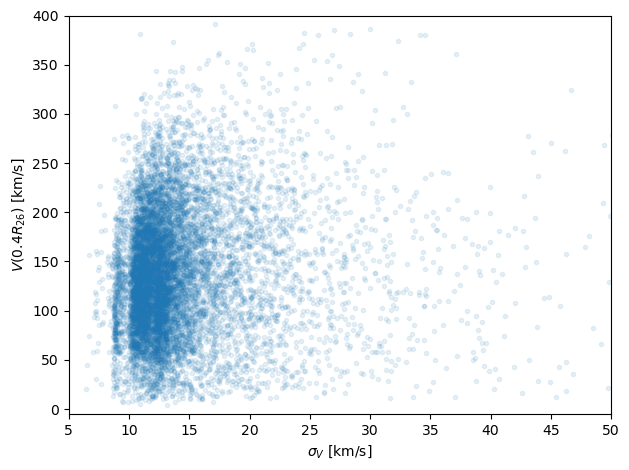

In [26]:
plt.figure(tight_layout=True)

plt.plot(SGA_TF_iron['V_0p4R26_ERR'], SGA_TF_iron['V_0p4R26'], '.', alpha=0.1)

plt.xlim(5,50)
plt.ylim(-5, 400)

plt.xlabel('$\sigma_V$ [km/s]')
plt.ylabel('$V(0.4R_{26})$ [km/s]');

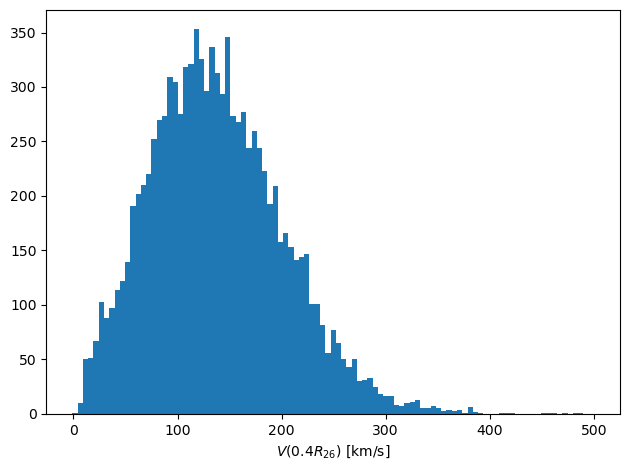

In [27]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF_iron['V_0p4R26'], bins=np.linspace(-1, 500, 100))

plt.xlabel('$V(0.4R_{26})$ [km/s]');

# Pull in `PHOTSYS` column

In [28]:
# photsys = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
photsys = Table.read('SGA-2020_iron_Vrot_VI_photsys.fits')

In [29]:
SGA_TF_iron_photsys = join(SGA_TF_iron, photsys['SGA_ID', 'PHOTSYS'], 
                           keys='SGA_ID')

# Write final catalog to file

In [31]:
# SGA_TF_iron.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot.fits')
# SGA_TF_iron_photsys.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits', 
SGA_TF_iron_photsys.write('SGA-2020_iron_Vrot_VI_corr.fits',
                          overwrite=True)

In [ ]:
#SGA_TF_iron_photsys.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys_v2.fits'

# Compare the updated velocity uncertainties to the previous uncertainties

In [30]:
# orig = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
orig = Table.read('/Users/kdouglass/Documents/Research/data/DESI/Y1/DESI-DR1_TF_pv_cat_v14.fits')

# mod = Table.read('SGA-2020_iron_Vrot_VI_corr.fits')

In [31]:
# Join two tables together for comparisons
old1_new2 = join(SGA_TF_iron['SGA_ID', 'V_0p4R26', 'V_0p4R26_ERR'], 
                 orig['SGA_ID', 'V_0p4R26', 'V_0p4R26_ERR'], 
                 keys='SGA_ID')
old1_new2

SGA_ID,V_0p4R26_1,V_0p4R26_ERR_1,V_0p4R26_2,V_0p4R26_ERR_2
float64,float64,float64,float64,float64
38.0,122.3223893029039,11.198383344229514,122.32238811543634,11.198383235519104
55.0,71.31450420590808,13.874518565192549,81.45040086564465,8.96603076461634
117.0,180.6557315191658,13.98823455452245,180.65572517100514,13.988234062982217
223.0,70.1020042633194,12.06703103243038,70.10200300303902,12.067030815491611
581.0,133.77852107143553,11.02226902919534,133.77852340476574,11.02226922144289
669.0,292.50047126155704,16.892595061217534,292.50050130867885,16.892596796509988
731.0,81.61279266055006,11.940465585971022,81.61279338923849,11.94046569258273
1135.0,201.8106175790663,11.595845192175995,218.68085076744163,7.017316819104426
1158.0,177.66056756020413,10.913290770989647,177.6605660298364,10.913290676982584


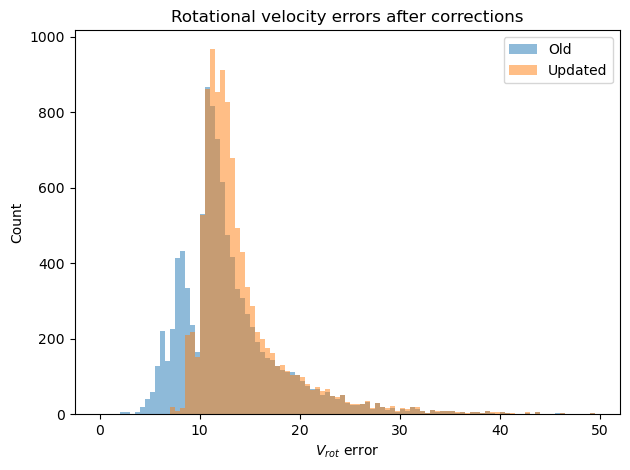

In [32]:
plt.figure(tight_layout=True)

plt.hist(orig['V_0p4R26_ERR'], bins=np.arange(0,50,0.5), alpha=0.5, label='Old')
plt.hist(SGA_TF_iron_photsys['V_0p4R26_ERR'], alpha=0.5, bins=np.arange(0,50,0.5), label='Updated')

plt.title('Rotational velocity errors after corrections')
plt.xlabel(r'$V_{rot}$ error')
plt.ylabel('Count')
plt.legend();

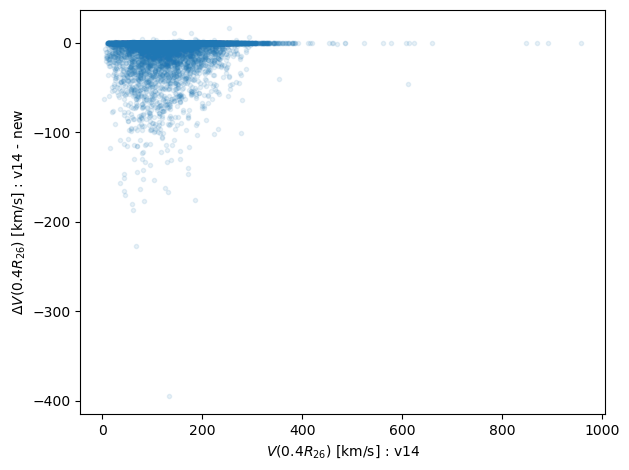

In [33]:
plt.figure(tight_layout=True)

plt.plot(old1_new2['V_0p4R26_1'], old1_new2['V_0p4R26_1'] - old1_new2['V_0p4R26_2'], '.', alpha=0.1)

plt.xlabel('$V(0.4R_{26})$ [km/s] : v14')
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s] : v14 - new');

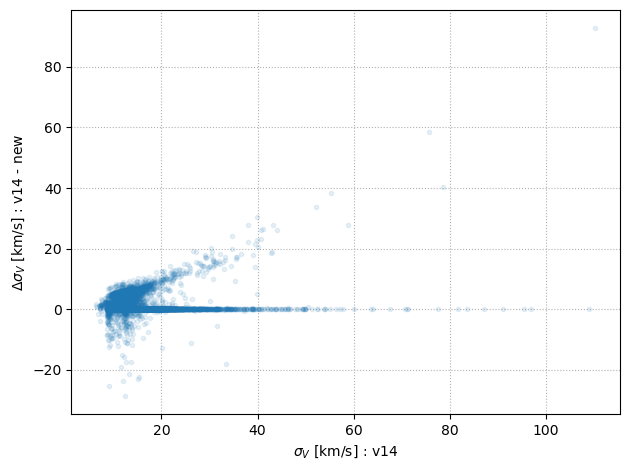

In [34]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot(old1_new2['V_0p4R26_ERR_1'], old1_new2['V_0p4R26_ERR_1'] - old1_new2['V_0p4R26_ERR_2'], '.', alpha=0.1)

# plt.xlim(0, 50)
# plt.ylim(-1, 10)

plt.xlabel('$\sigma_V$ [km/s] : v14')
plt.ylabel('$\Delta \sigma_V$ [km/s] : v14 - new');

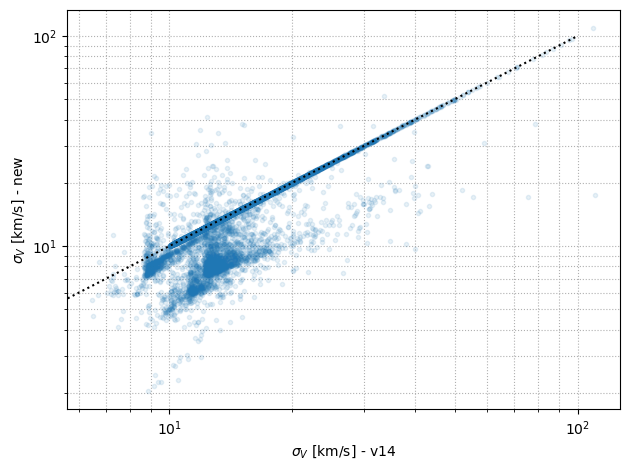

In [39]:
plt.figure(tight_layout=True)

plt.grid(ls=':', which='both')

plt.loglog(old1_new2['V_0p4R26_ERR_1'], old1_new2['V_0p4R26_ERR_2'], '.', alpha=0.1)

plt.loglog([0,100], [0,100], 'k:')

# plt.xlim(0,2000)
# plt.ylim(0,100)

plt.xlabel('$\sigma_V$ [km/s] - v14')
plt.ylabel('$\sigma_V$ [km/s] - new');

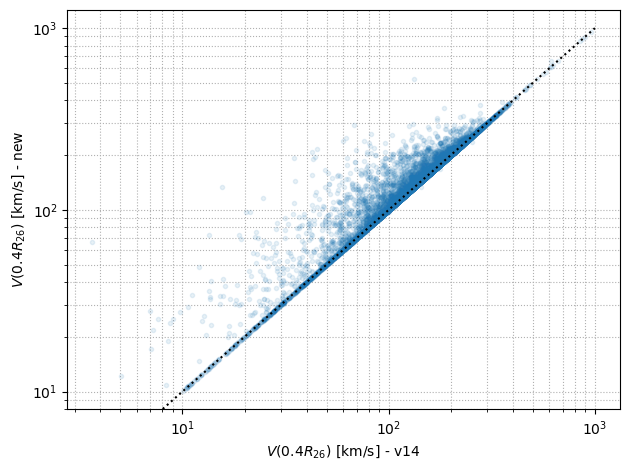

In [40]:
plt.figure(tight_layout=True)

plt.grid(ls=':', which='both')

plt.loglog(old1_new2['V_0p4R26_1'], old1_new2['V_0p4R26_2'], '.', alpha=0.1)

plt.loglog([0,1000], [0,1000], 'k:')

# plt.xlim(0,2000)
# plt.ylim(0,100)

plt.xlabel('$V(0.4R_{26})$ [km/s] - v14')
plt.ylabel('$V(0.4R_{26})$ [km/s] - new');